Task 1

In [7]:
import numpy as np

class MLP:
    def __init__(self, input_dim, layers, activation='relu'):
        self.layers = layers
        self.activation = activation
        self.weights = []
        self.biases = []
        
        prev_dim = input_dim
        for layer_dim in layers:
            self.weights.append(np.random.randn(prev_dim, layer_dim) * 0.01)
            self.biases.append(np.zeros((1, layer_dim)))
            prev_dim = layer_dim
    
    def _activate(self, x, derivative=False):
        """Applies activation function and computes its derivative."""
        if self.activation == 'relu':
            if derivative:
                return (x > 0).astype(float)
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            sig = 1 / (1 + np.exp(-x))
            if derivative:
                return sig * (1 - sig)
            return sig
    
    def forward(self, X):
        """Performs forward pass and stores activations for backpropagation."""
        self.a = [X]  # Store input as first activation
        self.z = []   # Store pre-activation values

        a = X
        for W, b in zip(self.weights, self.biases):
            z = np.dot(a, W) + b
            self.z.append(z)
            a = self._activate(z)
            self.a.append(a)  # Store activation for each layer

        return a
    
    def backward(self, X, y, lr=0.01):
        """Performs backpropagation and updates weights."""
        m = X.shape[0]  # Batch size
        dW, db = [], []

        # Compute output layer error
        dz = self.a[-1] - y  

        # Backpropagate through layers
        for i in reversed(range(len(self.layers))):
            dW.insert(0, np.dot(self.a[i].T, dz) / m)
            db.insert(0, np.sum(dz, axis=0, keepdims=True) / m)

            if i > 0:
                dz = np.dot(dz, self.weights[i].T) * self._activate(self.z[i-1], derivative=True)

        # Update weights
        for i in range(len(self.layers)):
            self.weights[i] -= lr * dW[i]
            self.biases[i] -= lr * db[i]
    
    def train(self, X, y, epochs=100, lr=0.01, verbose=True):
        """Train the network using gradient descent."""
        for epoch in range(epochs):
            self.forward(X)
            self.backward(X, y, lr)
            if verbose and epoch % 10 == 0:
                loss = np.mean((self.a[-1] - y) ** 2)
                print(f"Epoch {epoch}, Loss: {loss:.4f}")


In [5]:
import numpy as np

class CNN:
    def __init__(self, input_shape, filter_size, num_filters, fc_layers, activation='relu'):
        self.input_shape = input_shape  
        self.filter_size = filter_size  
        self.num_filters = num_filters  
        self.activation = activation 
        
        self.filters = np.random.randn(num_filters, filter_size, filter_size) * 0.01
        self.fc = MLP(input_dim=num_filters * (input_shape[0] - filter_size + 1) * 
                      (input_shape[1] - filter_size + 1), layers=fc_layers, activation=activation)
    
    def _activate(self, x, derivative=False):
        if self.activation == 'relu':
            return np.maximum(0, x) if not derivative else (x > 0).astype(float)
        elif self.activation == 'sigmoid':
            sig = 1 / (1 + np.exp(-x))
            return sig if not derivative else sig * (1 - sig)

    def _convolve(self, X):
        output_dim = X.shape[0] - self.filter_size + 1
        convolved = np.zeros((self.num_filters, output_dim, output_dim))
        
        for f in range(self.num_filters):
            for i in range(output_dim):
                for j in range(output_dim):
                    convolved[f, i, j] = np.sum(X[i:i+self.filter_size, j:j+self.filter_size] * self.filters[f])
        
        return self._activate(convolved)

    def forward(self, X):
        self.conv_out = self._convolve(X)
        fc_input = self.conv_out.flatten().reshape(1, -1)
        return self.fc.forward(fc_input)

    def backward(self, X, y, lr=0.01):
        self.fc.backward(self.conv_out.flatten().reshape(1, -1), y, lr)
        dL_dconv = self.fc.weights[0].T.dot(self.fc.a[0] - y).reshape(self.conv_out.shape)
        
        for f in range(self.num_filters):
            for i in range(dL_dconv.shape[1]):
                for j in range(dL_dconv.shape[2]):
                    self.filters[f] -= lr * dL_dconv[f, i, j] * X[i:i+self.filter_size, j:j+self.filter_size]

    def train(self, X, y, epochs=100, lr=0.01):
        for epoch in range(epochs):
            self.forward(X)
            self.backward(X, y, lr)
            if epoch % 10 == 0:
                print(f"Epoch {epoch} training CNN")


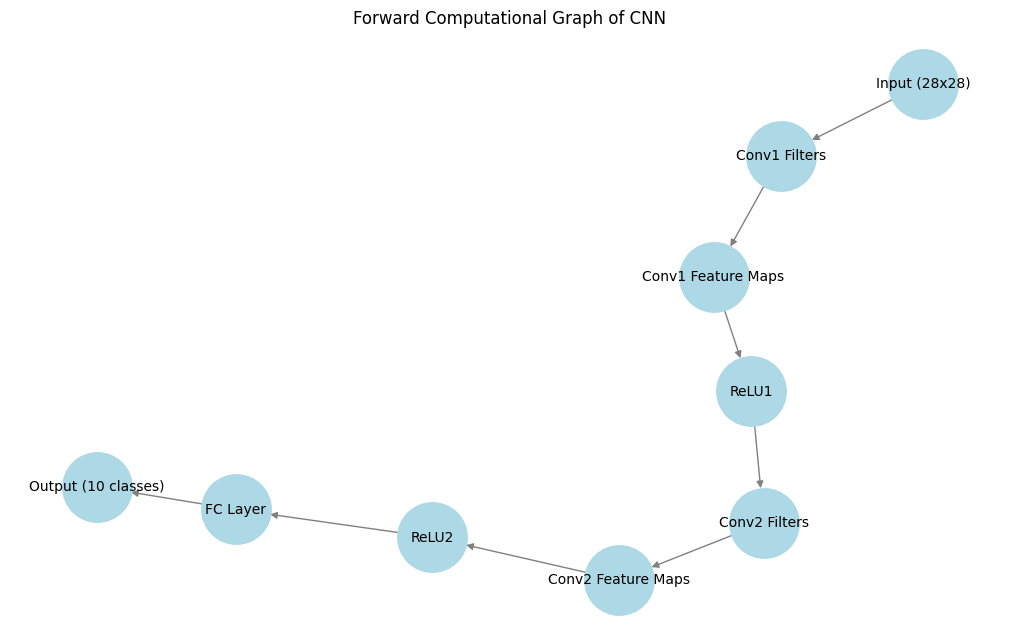

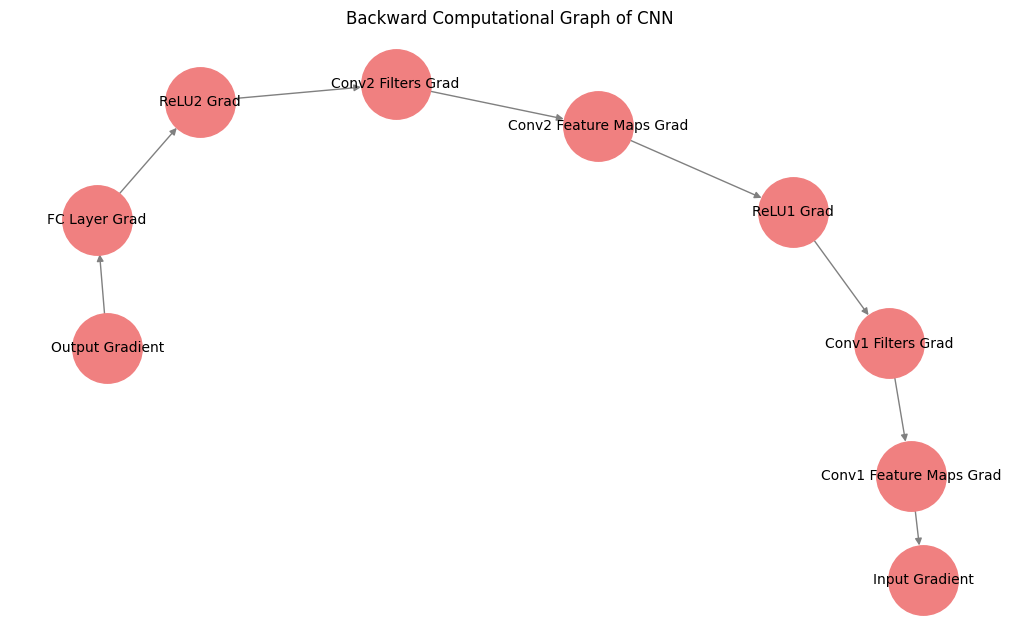

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_cnn_graph():
    G = nx.DiGraph()

    # Nodes
    G.add_nodes_from([
        "Input (28x28)", "Conv1 Filters", "Conv1 Feature Maps", "ReLU1",
        "Conv2 Filters", "Conv2 Feature Maps", "ReLU2",
        "FC Layer", "Output (10 classes)"
    ])

    # Forward Edges
    G.add_edges_from([
        ("Input (28x28)", "Conv1 Filters"),
        ("Conv1 Filters", "Conv1 Feature Maps"),
        ("Conv1 Feature Maps", "ReLU1"),
        ("ReLU1", "Conv2 Filters"),
        ("Conv2 Filters", "Conv2 Feature Maps"),
        ("Conv2 Feature Maps", "ReLU2"),
        ("ReLU2", "FC Layer"),
        ("FC Layer", "Output (10 classes)")
    ])

    # Draw the forward pass graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2500, font_size=10)
    plt.title("Forward Computational Graph of CNN")
    plt.show()

def draw_cnn_backward_graph():
    G = nx.DiGraph()

    # Nodes for Backward Propagation
    G.add_nodes_from([
        "Output Gradient", "FC Layer Grad", "ReLU2 Grad",
        "Conv2 Filters Grad", "Conv2 Feature Maps Grad",
        "ReLU1 Grad", "Conv1 Filters Grad", "Conv1 Feature Maps Grad",
        "Input Gradient"
    ])

    # Backward Edges
    G.add_edges_from([
        ("Output Gradient", "FC Layer Grad"),
        ("FC Layer Grad", "ReLU2 Grad"),
        ("ReLU2 Grad", "Conv2 Filters Grad"),
        ("Conv2 Filters Grad", "Conv2 Feature Maps Grad"),
        ("Conv2 Feature Maps Grad", "ReLU1 Grad"),
        ("ReLU1 Grad", "Conv1 Filters Grad"),
        ("Conv1 Filters Grad", "Conv1 Feature Maps Grad"),
        ("Conv1 Feature Maps Grad", "Input Gradient")
    ])

    # Draw the backward pass graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightcoral', edge_color='gray', node_size=2500, font_size=10)
    plt.title("Backward Computational Graph of CNN")
    plt.show()

# Generate graphs
draw_cnn_graph()
draw_cnn_backward_graph()


Task 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.datasets import mnist

# Load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalize
y_train_onehot = np.eye(10)[y_train]  
y_test_onehot = np.eye(10)[y_test]


2025-03-14 20:25:26.901904: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 20:25:28.355177: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 20:25:28.388689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-14 20:25:32.959954: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:

# Train MLP
mlp = MLP(input_dim=28*28, layers=[128, 64, 10], activation='relu')
mlp.train(X_train.reshape(-1, 28*28), y_train_onehot, epochs=100, lr=0.01)

# Train CNN properly over the dataset
cnn = CNN(input_shape=(28, 28), filter_size=3, num_filters=8, fc_layers=[10], activation='relu')

for epoch in range(100):
    for i in range(len(X_train)):
        cnn.train(X_train[i], y_train_onehot[i], epochs=1, lr=0.01)  # Train sample by sample

# Predictions
mlp_preds = np.argmax(mlp.forward(X_test.reshape(-1, 28*28)), axis=1)

cnn_preds = []
for i in range(100):  # Predict 100 test samples
    cnn_preds.append(np.argmax(cnn.forward(X_test[i])))

cnn_preds = np.array(cnn_preds)

# Confusion matrices
mlp_cm = confusion_matrix(y_test, mlp_preds)
cnn_cm = confusion_matrix(y_test[:100], cnn_preds)

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(mlp_cm).plot(ax=ax[0])
ax[0].set_title("MLP Confusion Matrix")
ConfusionMatrixDisplay(cnn_cm).plot(ax=ax[1])
ax[1].set_title("CNN Confusion Matrix")
plt.show()


Epoch 0, Loss: 0.1000
Epoch 10, Loss: 0.0982
Epoch 20, Loss: 0.0967
Epoch 30, Loss: 0.0954
Epoch 40, Loss: 0.0944
Epoch 50, Loss: 0.0936
Epoch 60, Loss: 0.0929
Epoch 70, Loss: 0.0924
Epoch 80, Loss: 0.0920
Epoch 90, Loss: 0.0916


ValueError: operands could not be broadcast together with shapes (1,5408) (10,) 